In [303]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [304]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.cosmology import FlatLambdaCDM
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [305]:
# LOAD DATA AND KEEP ONLY Z SLICE OF INTEREST

data = ascii.read('5MUSES.dat')
  
z1_slice=0
z2_slice=0.3

in_slice=(data["z"]>z1_slice) & (data["z"]<z2_slice)
data=data[in_slice]

z,f24,logLIR,=data["z"],data["F24"],data["logLIR"] #No luminosity limits
data


ID,Name,RAh,RAm,RAs,DE-,DEd,DEm,DEs,z,f_z,F24,l_EW6.2,EW6.2,e_EW6.2,logLIR,e_logLIR
,,h,min,s,,deg,arcmin,arcsec,,,mJy,,um,um,dex(Lsun),dex(Lsun)
str10,str26,int32,int32,float64,str1,int32,int32,float64,float64,int32,float64,str1,float64,float64,float64,float64
5MUSES-002,5MUSES_J021503.52-042421.6,2,15,3.5,-,4,24,21.7,0.137,2,5.2,--,0.776,0.009,10.89,0.02
5MUSES-004,5MUSES_J021557.11-033729.0,2,15,57.1,-,3,37,29.1,0.032,2,8.8,--,0.504,0.048,9.8,0.03
5MUSES-008,5MUSES_J021649.71-042554.8,2,16,49.7,-,4,25,54.8,0.143,2,10.1,--,1.107,0.057,11.01,0.07
5MUSES-009,5MUSES_J021657.77-032459.7,2,16,57.8,-,3,24,59.8,0.137,1,23.8,<,0.062,--,10.9,0.03
5MUSES-012,5MUSES_J021743.82-051751.7,2,17,43.8,-,5,17,51.8,0.031,1,17.1,--,0.645,0.08,10.11,0.03
5MUSES-013,5MUSES_J021754.88-035826.4,2,17,54.9,-,3,58,26.5,0.226,1,10.3,--,0.53,0.044,11.72,0.04
5MUSES-018,5MUSES_J021849.76-052158.2,2,18,49.8,-,5,21,58.2,0.292,1,5.3,--,0.571,0.058,11.63,0.03
5MUSES-019,5MUSES_J021859.74-040237.2,2,18,59.7,-,4,2,37.2,0.199,2,15.9,<,0.16,--,11.23,0.06


In [306]:
max(z)

0.293

[ 8.5  9.7 10.9 12.1 13.3] [  2.  36. 164.  14.   0.]


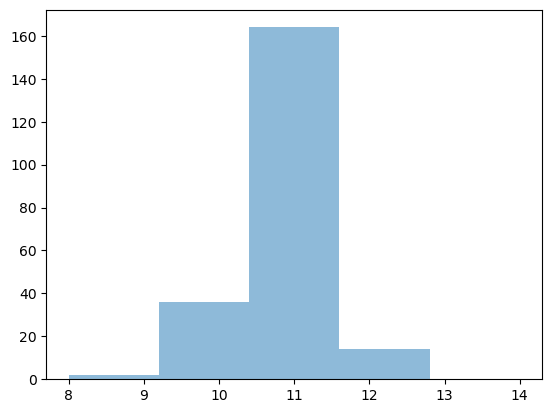

In [307]:
# First make a reference histogram for the number of sources per bin

lowerlimit,upperlimit,dexstep=8,14,1
number_of_bins=int((ulimit-llimit)/dexstep)

lfdata=plt.hist(logLIR, range=[lowerlimit,upperlimit],bins = number_of_bins,alpha=0.5)
default_counts=np.array(lfdata[0])
default_bin_centers=np.array(lfdata[1][0:-1])+dexstep/2
print(default_bin_centers,default_counts)

C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_11696\3886712472.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(bin_centers_all,counts_all,"o",marker=r'$\downarrow$',markersize=12)


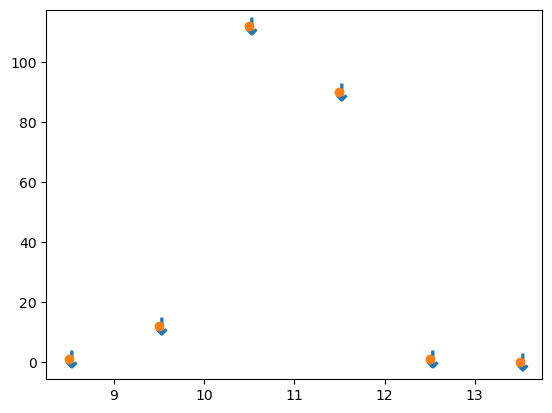

In [308]:
# a similar routine providing bins, but also taking into account flags, volume weights, ...
def bins_and_weights(lfdata,ll,ul,dexstep,dV,flags=[]):
    
    bin_centers=[]
    counts=[]
    weights_dV=[]
    
    number_of_bins=int((ul-ll)/dexstep)
    number_of_sources=lfdata.size
    if (np.array(flags).size != number_of_sources): flags=np.ones(number_of_sources)
    
    for b in range(number_of_bins):
        nb,wb=0.,0.                          # number of sources in each bin, weight in each bin
        for i in range(number_of_sources): 
            if (int(flags[i]) != 1): continue
            if (lfdata[i] < ll+b*dexstep or lfdata[i] >= ll+(b+1)*dexstep): continue
            #print(ll+b*dexstep,"->", ll+(b+1)*dexstep,": ", lfdata[i],"( V=", dV[i],")")
            nb=nb+1
            wb=wb+(1./dV[i])
            
        counts.append(nb)
        weights_dV.append(wb)
        bin_centers.append(  ( (ll+b*dexstep)+(ll+(b+1)*dexstep) )/2.)
        #print("\n")
    
    
    return np.array(bin_centers),np.array(counts),np.array(weights_dV)


bin_centers_all,counts_all,sum_1_dV_all = bins_and_weights(logLIR,lowerlimit,upperlimit,dexstep,np.ones(np.size(z)))
plt.plot(bin_centers_all,counts_all,"o",marker=r'$\downarrow$',markersize=12)

bin_centers_det,counts_det,sum_1_dV_det=bins_and_weights(logLIR,lowerlimit,upperlimit,dexstep,np.ones(np.size(z)))
plt.plot(bin_centers_det,counts_det,"o")



In [309]:
# Make a very first attempt of a luminosity function (number of sources / dex / Mpc^3):

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
D=cosmo.luminosity_distance(z).value # in Mpc 

# Compute the volume of the survey:
Omega = 0.01236676 # 40.6 deg^2
V = Omega/3 * (cosmo.luminosity_distance(z).value/(1+z))**3

Vmax = Omega/3 * (cosmo.luminosity_distance(z2_slice).value/(1+z2_slice))**3
Vmin = Omega/3 * (cosmo.luminosity_distance(z1_slice).value/(1+z1_slice))**3

dV=(Vmax-Vmin)



In [310]:
# Compute the density of sources in the sky: it should be representative of the parent catalog:
# i.e., number of sources / Omega /z in our survey and in the parent sample should be the same



N_SWIRE=1111


N_our=330 #Subtotal of the SWIRE Field the 5MUSES survey looked at
N_our_in_z=np.size(z)


w= N_our_in_z/N_SWIRE
print("Weight to divide by to be as dense as SWIRE:",w)

# Compute the luminosity function:

lum_f_fixed_V = counts_all / dexstep / dV / w 




Weight to divide by to be as dense as SWIRE: 0.19441944194419442


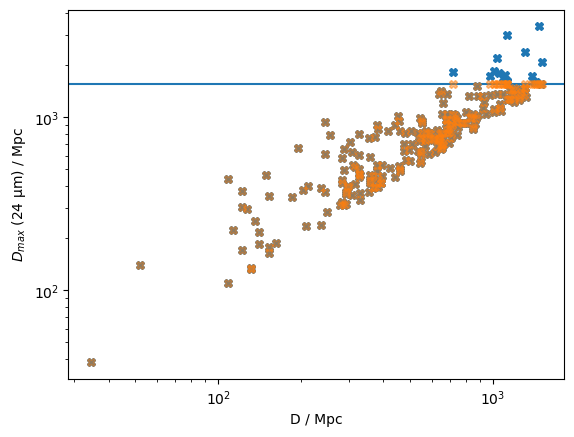

In [311]:
# HOW TO FIX the fact the actual detection volume
# COMPUTE D_MAX per source instead of D - out to how high z could it be detected?

# 1. Using the detection limit for the 24μm flux
f24_surveylimit=5# mJy
kcorrection=1 # consider the synctrotron power-law here!
D_max24 = D * np.sqrt( f24 / f24_surveylimit /kcorrection )

# 2. Using the detection limit for CO
# This we won't do here, but it is similar 
# D_max_CO = D * np.sqrt( fco / fco_limit  )


# Keep the smallest of the Distances for the sum(1/Vmax(i))
D_max=D_max24

plt.plot(D, D_max24,"X")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("D / Mpc")
plt.ylabel("$D_{max}$ (24 μm) / Mpc")

D2_slice = cosmo.luminosity_distance(z2_slice).value
plt.axhline(y=D2_slice)

D_max[D_max>D2_slice]=D2_slice   # If a source could be detected further away, stop its correction at D2_slice
plt.plot(D, D_max24,"X",alpha=0.5)


# Find the corresponding zmax for Vmax, needed for the volume weights
z_max=z-z
from astropy.cosmology import z_at_value
from astropy import units as u
for i in range(z.size): z_max=z_at_value(cosmo.luminosity_distance,D_max[i]*u.Mpc)

Vmax= Omega/3 * (D_max/(1+z_max))**3
Vmin= Omega/3 * (cosmo.luminosity_distance(z1_slice).value/(1+z1_slice))**3

dVmax=Vmax.value-Vmin


bin_centers_all,counts_all,sum_1_dVmax_all = bins_and_weights(logLIR,lowerlimit,upperlimit,dexstep,dVmax)

lum_f = sum_1_dVmax_all / dexstep / w 


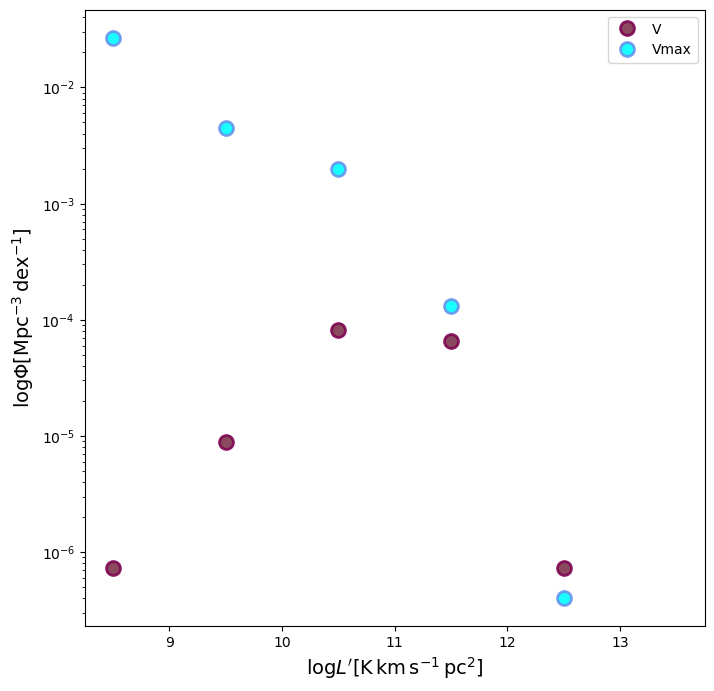

In [312]:
fig , ax= plt.subplots(figsize=(8,8))

plt.plot(bin_centers_all, lum_f_fixed_V, 'o', color='#7E354D', markersize=10,markeredgecolor='#7D0552',markeredgewidth=2,alpha=0.9,label='V')

plt.plot(bin_centers_all, lum_f, 'o', color='cyan', markersize=10,markeredgecolor='cornflowerblue',markeredgewidth=2,alpha=0.9,label='Vmax')

plt.yscale('log')
plt.legend()
plt.ylabel("log$\Phi$[$\\rm Mpc^{-3}\,dex^{-1}$]",size=14)
plt.xlabel("log$L'$[$\\rm K\,km\,s^{-1}\,pc^2$]", size=14)
plt.show()